Library

In [40]:
import numpy as np
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from tslearn.clustering import TimeSeriesKMeans
from tslearn import metrics

from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

seed = 0
np.random.seed(seed)

We first import the time series and preprocess the data. Using the covid_19_clean_complete.csv

In [23]:
df_covid = pd.read_csv("covid_19_clean_complete.csv")
df_covid

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe


Convert each date to a date time

In [3]:
df_covid["Date"] = pd.to_datetime(df_covid["Date"])

In [4]:
# info of data
df_covid.info()

# display
df_covid

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49068 entries, 0 to 49067
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Province/State  14664 non-null  object        
 1   Country/Region  49068 non-null  object        
 2   Lat             49068 non-null  float64       
 3   Long            49068 non-null  float64       
 4   Date            49068 non-null  datetime64[ns]
 5   Confirmed       49068 non-null  int64         
 6   Deaths          49068 non-null  int64         
 7   Recovered       49068 non-null  int64         
 8   Active          49068 non-null  int64         
 9   WHO Region      49068 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 3.7+ MB


,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
0,NaN,Afghanistan,33.939110,67.709953,2020-01-22,0,0,0,0,Eastern Mediterranean
1,NaN,Albania,41.153300,20.168300,2020-01-22,0,0,0,0,Europe
2,NaN,Algeria,28.033900,1.659600,2020-01-22,0,0,0,0,Africa
3,NaN,Andorra,42.506300,1.521800,2020-01-22,0,0,0,0,Europe
4,NaN,Angola,-11.202700,17.873900,2020-01-22,0,0,0,0,Africa
...,...,...,...,...,...,...,...,...,...,...
49063,NaN,Sao Tome and Principe,0.186400,6.613100,2020-07-27,865,14,734,117,Africa
49064,NaN,Yemen,15.552727,48.516388,2020-07-27,1691,483,833,375,Eastern Mediterranean
49065,NaN,Comoros,-11.645500,43.333300,2020-07-27,354,7,328,19,Africa
49066,NaN,Tajikistan,38.861000,71.276100,2020-07-27,7235,60,6028,1147,Europe


Length of each time series per country

In [11]:
df_covid.groupby(["Date","Country/Region"]).agg('sum').reset_index()

,Date,Country/Region,Lat,Long,Confirmed,Deaths,Recovered,Active
0,01 Apr,Afghanistan,33.939110,67.709953,237,4,5,228
1,01 Apr,Albania,41.153300,20.168300,259,15,67,177
2,01 Apr,Algeria,28.033900,1.659600,847,58,61,728
3,01 Apr,Andorra,42.506300,1.521800,390,14,10,366
4,01 Apr,Angola,-11.202700,17.873900,8,2,1,5
...,...,...,...,...,...,...,...,...
35151,31 May,West Bank and Gaza,31.952200,35.233200,448,3,372,73
35152,31 May,Western Sahara,24.215500,-12.885800,9,1,6,2
35153,31 May,Yemen,15.552727,48.516388,323,80,14,229
35154,31 May,Zambia,-13.133897,27.849332,1057,7,779,271


In [24]:
selected_countries = df_covid["Country/Region"].value_counts().reset_index(name="count").query("count > 500")['index']
df_covid_filtered = df_covid[df_covid['Country/Region'].isin(selected_countries)]

In [25]:
df_covid_filtered

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active,WHO Region
8,Australian Capital Territory,Australia,-35.4735,149.0124,2020-01-22,0,0,0,0,Western Pacific
9,New South Wales,Australia,-33.8688,151.2093,2020-01-22,0,0,0,0,Western Pacific
10,Northern Territory,Australia,-12.4634,130.8456,2020-01-22,0,0,0,0,Western Pacific
11,Queensland,Australia,-27.4698,153.0251,2020-01-22,0,0,0,0,Western Pacific
12,South Australia,Australia,-34.9285,138.6007,2020-01-22,0,0,0,0,Western Pacific
...,...,...,...,...,...,...,...,...,...,...
49052,Anguilla,United Kingdom,18.2206,-63.0686,2020-07-27,3,0,3,0,Europe
49053,British Virgin Islands,United Kingdom,18.4207,-64.6400,2020-07-27,8,1,7,0,Europe
49054,Turks and Caicos Islands,United Kingdom,21.6940,-71.7979,2020-07-27,99,2,36,61,Europe
49059,Falkland Islands (Malvinas),United Kingdom,-51.7963,-59.5236,2020-07-27,13,0,13,0,Europe


Display the curves corresponding to the data frame ```df_covid_filtered```

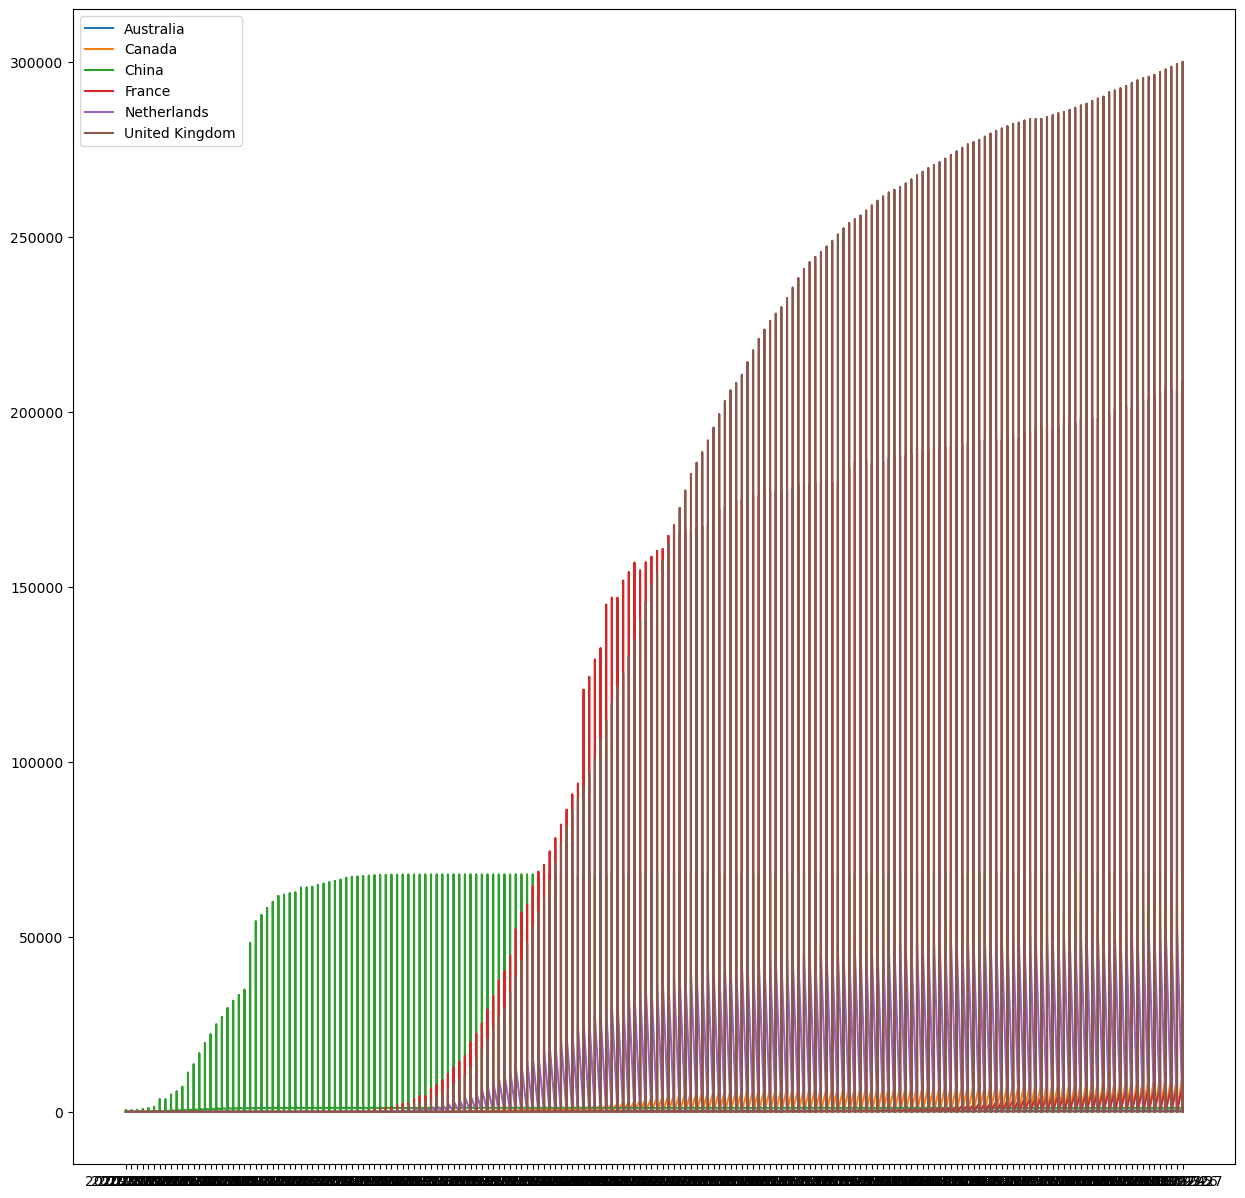

In [26]:
from matplotlib import pyplot as plt

fig, ax1= plt.subplots(nrows = 1, ncols = 1,figsize=(15,15))
for key, grp in df_covid_filtered.groupby(['Country/Region']):
    ax1.plot(grp['Date'], grp['Confirmed'], label = "{}".format(key))
plt.legend(loc='best')
plt.show()

Transform the data to the seris bay array:

In [27]:
# df_covid_filtered['Date'] = pd.to_datetime(df_covid_filtered['Date'])
df_covid_filtered['Date'] = df_covid_filtered['Date'].astype('datetime64[ns]')

C:\Users\Le Cao Tung Lam\AppData\Local\Temp\ipykernel_43084\2067177202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid_filtered['Date'] = df_covid_filtered['Date'].astype('datetime64[ns]')


In [28]:
df_covid_pivot = df_covid.reset_index().pivot_table(index='Date', columns='Country/Region', values='Confirmed', aggfunc = 'sum')

In [30]:
# Transposing
df_covid_pivot = df_covid_pivot.T

In [31]:
df_covid_pivot

Date,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,35301,35475,35526,35615,35727,35928,35981,36036,36157,36263
Albania,0,0,0,0,0,0,0,0,0,0,...,4008,4090,4171,4290,4358,4466,4570,4637,4763,4880
Algeria,0,0,0,0,0,0,0,0,0,0,...,22549,23084,23691,24278,24872,25484,26159,26764,27357,27973
Andorra,0,0,0,0,0,0,0,0,0,0,...,880,880,884,884,889,889,897,897,897,907
Angola,0,0,0,0,0,0,0,0,0,0,...,687,705,749,779,812,851,880,916,932,950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,8204,8549,8916,9228,9398,9744,10093,10306,10469,10621
Western Sahara,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
Yemen,0,0,0,0,0,0,0,0,0,0,...,1581,1606,1619,1629,1640,1654,1674,1674,1681,1691


Convert ```df_covid_pivot``` into numpy array

In [32]:
ts_array = np.array(df_covid_pivot).reshape(df_covid_pivot.shape[0],df_covid_pivot.shape[1],1)
ts_array

array([[[    0],
        [    0],
        [    0],
        ...,
        [36036],
        [36157],
        [36263]],

       [[    0],
        [    0],
        [    0],
        ...,
        [ 4637],
        [ 4763],
        [ 4880]],

       [[    0],
        [    0],
        [    0],
        ...,
        [26764],
        [27357],
        [27973]],

       ...,

       [[    0],
        [    0],
        [    0],
        ...,
        [ 1674],
        [ 1681],
        [ 1691]],

       [[    0],
        [    0],
        [    0],
        ...,
        [ 4328],
        [ 4481],
        [ 4552]],

       [[    0],
        [    0],
        [    0],
        ...,
        [ 2434],
        [ 2512],
        [ 2704]]], dtype=int64)

Why do we reshape ?

We now perform clustering

We first use Euclidean distance between time series

Perform K-means

In [ ]:

from tslearn.clustering import TimeSeriesKMeans

plt.figure(figsize=(20,15))
sz = ts_array.shape[1]

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=4,
                          n_init=2,
                          metric="dtw",
                          verbose=True,
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred = dba_km.fit_predict(ts_array)
labels = dict(zip(df_covid_pivot.index, y_pred))

Plot the curves that belong to each cluster

Init 1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


132825929247.481 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


25268617185.096 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23925580740.687 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23881475852.097 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23856036420.795 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225757.800 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225741.039 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225724.279 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225707.518 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225690.757 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225673.997 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225657.236 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225640.476 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225623.715 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225606.954 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225590.194 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225573.433 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225556.673 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225539.912 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225523.151 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225506.391 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225489.630 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225472.870 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225456.109 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225439.348 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225422.588 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225405.827 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225389.067 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225372.306 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225355.545 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225338.785 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225322.024 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225305.270 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225288.518 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225271.767 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225255.015 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225238.263 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225221.511 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


23853225204.760 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225193.481 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


23853225193.481 --> 
Init 2


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 187 out of 187 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 561 out of 561 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


120093170182.733 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


25667825191.721 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24245110767.300 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24202325406.958 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185606777.550 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330288.697 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330271.936 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185330255.176 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330238.415 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330221.654 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330204.894 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185330188.133 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185330171.373 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185330154.612 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330137.851 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330121.091 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330104.330 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185330087.570 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330070.809 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330054.048 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330037.288 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330020.527 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185330003.767 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329987.006 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329970.245 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329953.485 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329936.724 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185329919.964 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329903.203 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329886.442 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329869.682 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329852.921 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329836.161 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329819.409 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185329802.658 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329785.906 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185329769.154 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185329752.402 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329735.651 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185329718.910 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.1s finished


24185329714.651 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


24185329714.651 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 748 out of 748 | elapsed:    0.2s finished


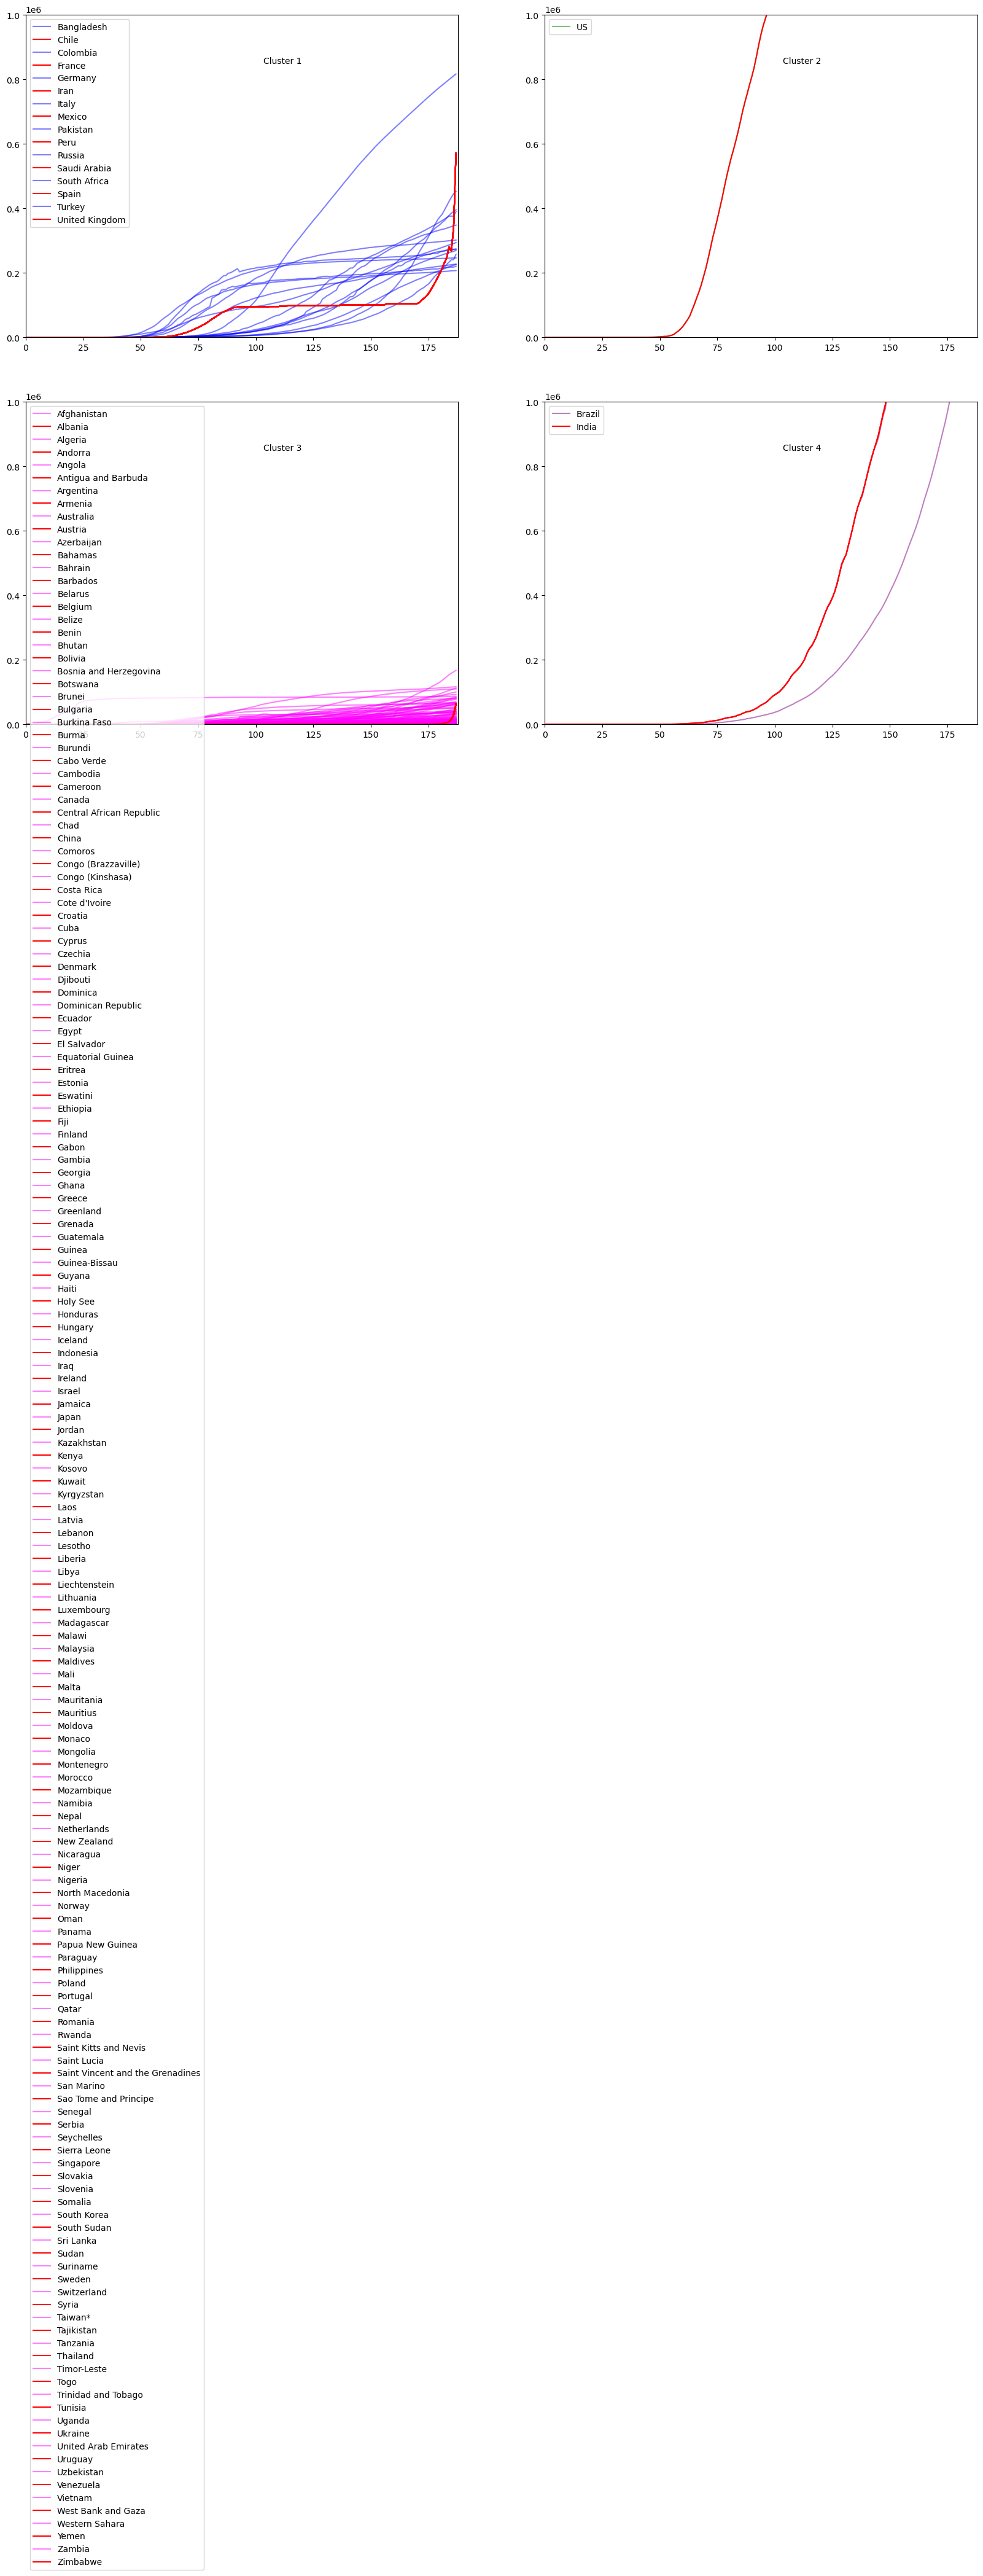

In [42]:
plt.figure(figsize=(20,15))
sz = ts_array.shape[1]
y_pred = dba_km.fit_predict(ts_array)
labels = dict(zip(df_covid_pivot.index, y_pred))

for yi in range(4):
    plt.subplot(2, 2, 1 + yi)
    for xx in ts_array[y_pred == yi]:
        if yi == 0:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='blue' )
            plt.legend([ k for k, v in labels.items() if v == 0 ], loc ='upper left')
        elif yi == 1:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='green' )
            plt.legend([ k for k, v in labels.items() if v == 1 ], loc ='upper left')

        elif yi ==2:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='magenta' )
            plt.legend([ k for k, v in labels.items() if v == 2 ], loc ='upper left')

        else:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='purple' )
            plt.legend([ k for k, v in labels.items() if v == 3 ], loc ='upper left')

        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-5, 1000000)
    #plt.legend(df_excep.columns[1:],loc="upper left")
    plt.text(0.55, 0.85,'Cluster %d ' % (yi + 1),
             transform=plt.gca().transAxes)


We now use DTW

Perform K-means

In [43]:
plt.figure(figsize=(20,15))
sz = ts_array.shape[1]

# Soft dtw -  k means
print("Soft dtw k-means")
km = TimeSeriesKMeans(n_clusters=4,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           random_state=seed)
y_pred = km.fit_predict(ts_array)
labels = dict(zip(df_covid_pivot.index, y_pred))

Soft dtw k-means
383916081986704546725888.000 --> 29010035272405122809856.000 --> 29011300016082437275648.000 --> 29010590690690614689792.000 --> 29009428725651170394112.000 --> 29000702745644768428032.000 --> 28971408962623618678784.000 --> 28971209569856280068096.000 --> 28971054494039897276416.000 --> 28971045022253346455552.000 --> 28970966285285658198016.000 --> 28970952104362360438784.000 --> 28970622164751850930176.000 --> 28972202305288350466048.000 --> 28972190336886450946048.000 --> 28972153721209015500800.000 --> 28972166269961987162112.000 --> 28972167311560443691008.000 --> 28972181664713154756608.000 --> 28972142484136195522560.000 --> 28972112411547263827968.000 --> 28972076129709461602304.000 --> 28972083455746759458816.000 --> 28972168556477857923072.000 --> 28972178831176370225152.000 --> 28972131468946918342656.000 --> 28972081527609452658688.000 --> 28972144497376475742208.000 --> 28973680490853066342400.000 --> 28973674971692261179392.000 --> 2897367214711777735475

<Figure size 2000x1500 with 0 Axes>

Plot the curves that belong to each cluster

383916081986704546725888.000 --> 29010035272405122809856.000 --> 29011300016082437275648.000 --> 29010590690690614689792.000 --> 29009428725651170394112.000 --> 29000702745644768428032.000 --> 28971408962623618678784.000 --> 28971209569856280068096.000 --> 28971054494039897276416.000 --> 28971045022253346455552.000 --> 28970966285285658198016.000 --> 28970952104362360438784.000 --> 28970622164751850930176.000 --> 28972202305288350466048.000 --> 28972190336886450946048.000 --> 28972153721209015500800.000 --> 28972166269961987162112.000 --> 28972167311560443691008.000 --> 28972181664713154756608.000 --> 28972142484136195522560.000 --> 28972112411547263827968.000 --> 28972076129709461602304.000 --> 28972083455746759458816.000 --> 28972168556477857923072.000 --> 28972178831176370225152.000 --> 28972131468946918342656.000 --> 28972081527609452658688.000 --> 28972144497376475742208.000 --> 28973680490853066342400.000 --> 28973674971692261179392.000 --> 28973672147117777354752.000 --> 2897363

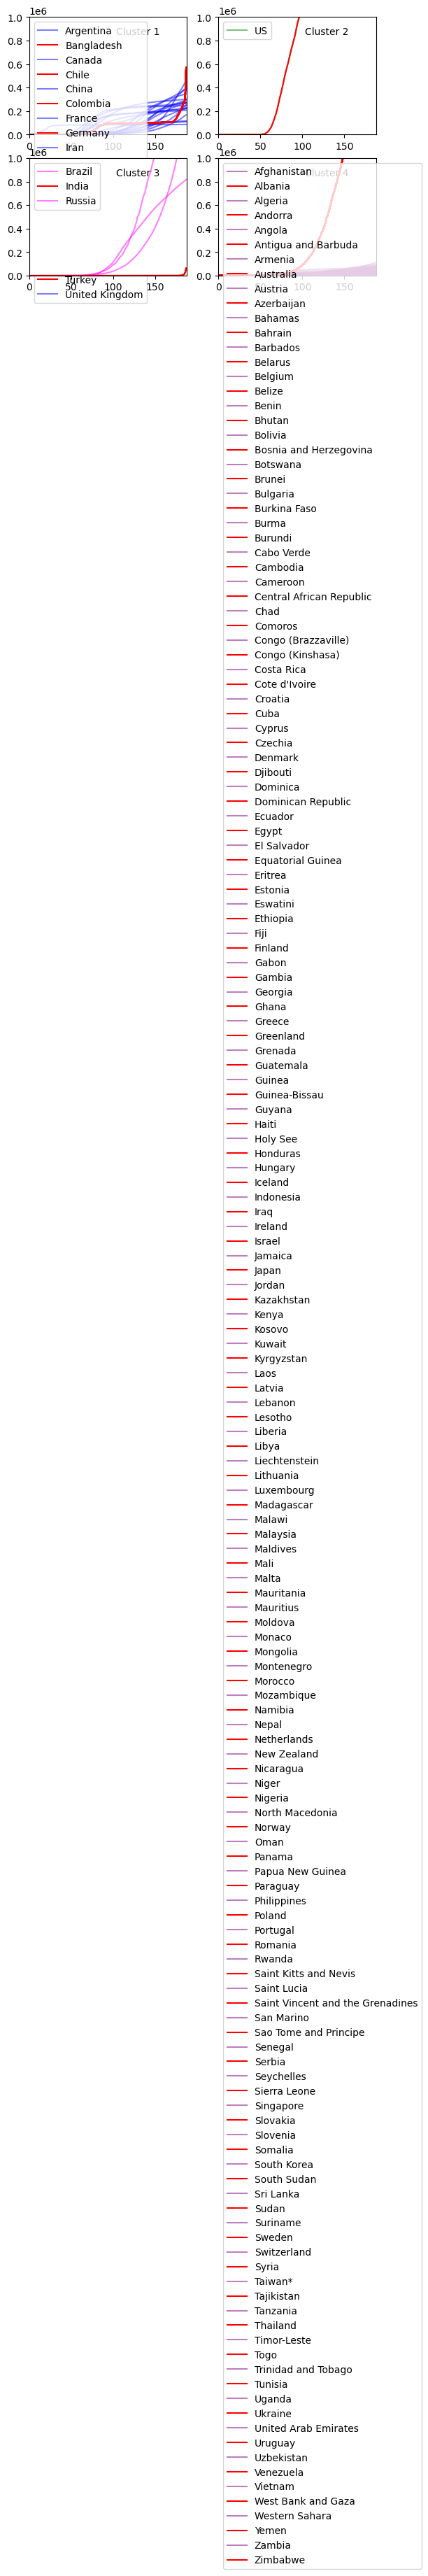

In [44]:
y_pred = km.fit_predict(ts_array)
labels = dict(zip(df_covid_pivot.index, y_pred))


for yi in range(4):
    plt.subplot(2, 2, 1 + yi)
    for xx in ts_array[y_pred == yi]:
        if yi == 0:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='blue' )
            plt.legend([ k for k, v in labels.items() if v == 0 ], loc ='upper left')
        elif yi == 1:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='green' )
            plt.legend([ k for k, v in labels.items() if v == 1 ], loc ='upper left')

        elif yi ==2:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='magenta' )
            plt.legend([ k for k, v in labels.items() if v == 2 ], loc ='upper left')

        else:
            plt.plot(xx.ravel(), "k-", alpha=.5, color ='purple' )
            plt.legend([ k for k, v in labels.items() if v == 3 ], loc ='upper left')

        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-5, 1000000)
    #plt.legend(df_excep.columns[1:],loc="upper left")
    plt.text(0.55, 0.85,'Cluster %d ' % (yi + 1),
             transform=plt.gca().transAxes)